## Demand Prediction using Machine Learning

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import calendar
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
import seaborn as sns
%matplotlib inline

In [2]:
df_initial = pd.read_pickle('./DemandDataFile', compression='infer')
df_region = pd.read_pickle('./RegionDataFile', compression='infer')
df_initial = pd.merge(df_initial, df_region, how='inner', right_on=['CITY_NAME'], left_on=['CITY'])
df_initial = df_initial.drop(['CITY_NAME'], axis=1)

df_initial = df_initial[~df_initial['PRODUCT_NAME'].str.contains("Small Flyers|Large Flyers|Meter Bubble Wrap|Bundle of 50 Boxes|Wrap", na=False)]
df_initial.rename(columns = {'ORDER_DATE':'DATE'},inplace = True)
df_initial.sort_values('DATE',ascending=True, inplace = True)
df_initial.DATE = pd.to_datetime(df_initial['DATE'])

df_reviews = pd.read_csv('./ProductReviews.csv')
df_initial = pd.merge(df_initial, df_reviews, how='left', right_on=['COD_SKU_CONFIG'], left_on=['SKU'])
df_initial = df_initial.drop(['COD_SKU_CONFIG'], axis=1)

In [3]:
df_fraud = pd.read_csv('./FradulentOrders.csv',dtype={'ORDER_NR': str})

df_initial = df_initial[~df_initial.COD_ORDER_NR.isin(df_fraud.ORDER_NR.tolist())]

df_initial['WareHouse'] = 'Null'
df_initial.loc[:,"WareHouse"][df_initial['REGION_NAME'].isin(['Sindh','Balochistan'])] = 'Karachi'
df_initial.loc[:,"WareHouse"][~df_initial['REGION_NAME'].isin(['Sindh','Balochistan'])] = 'Lahore'
#df_initial['WareHouse'].value_counts()

/home/danyal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/danyal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [4]:
def isHoliday(x):
    if x in df_hday18.Date.values:
        return 1
    else:
        return 0

In [5]:
df_hday18 = pd.read_csv('./Holidays2018.csv')
df_hday18.Date = pd.to_datetime(df_hday18['Date'])


In [6]:
#df_initial[df_initial.IsHoliday == 1].head()
df_initial.shape

(2683504, 23)

In [7]:
df_initial['MedianPrice'] = df_initial.groupby('SKU')['UNIT_PRICE'].transform('median')
df_initial['MedianPrice'] = pd.to_numeric(df_initial['MedianPrice'])

In [8]:
df_initial['CatConcat'] = df_initial[['PRODUCT_NAME','BRAND_NAME','CATEGORY_LEVEL_1', 'CATEGORY_LEVEL_2','CATEGORY_LEVEL_3','CATEGORY_LEVEL_4']].apply(lambda x: ' | '.join(x.str.strip()), axis=1)
df_initial.shape

(2683504, 25)

In [9]:
def compute_shift(df,dateCol,groupCol):
    df['group_no'] = df.groupby([groupCol]).ngroup()
    tmp = df[[dateCol,'Quantity','group_no']].set_index(['group_no',dateCol])\
                                          .unstack('group_no')\
                                          .resample('D').asfreq()
    tmp1 = tmp.shift(1).fillna(0).astype(int).stack('group_no')['Quantity'].rename('D1')
    tmp2 = tmp.shift(2).fillna(0).astype(int).stack('group_no')['Quantity'].rename('D2')
    tmp3 = tmp.shift(3).fillna(0).astype(int).stack('group_no')['Quantity'].rename('D3')
    tmp4 = tmp.shift(4).fillna(0).astype(int).stack('group_no')['Quantity'].rename('D4')
    tmp5 = tmp.shift(5).fillna(0).astype(int).stack('group_no')['Quantity'].rename('D5')
    
    df = df.join(tmp1, on=[dateCol,'group_no'])
    df = df.join(tmp2, on=[dateCol,'group_no'])
    df = df.join(tmp3, on=[dateCol,'group_no'])
    df = df.join(tmp4, on=[dateCol,'group_no'])
    df = df.join(tmp5, on=[dateCol,'group_no'])
    
    df.drop(axis=1, columns=['group_no'], inplace = True)
    return df

In [10]:
def log_inf(x):
    if x>0:
        return np.log(x) 
    else:
        return np.log(1) 

def is_bundle(x):
    if 'Bundle' in x or 'Pack' in x or '+' in x:
        return 1
    else:
        return 0


In [11]:
def product_Gender(x):
    if 'Men' in x:
        return 'MEN'
    elif 'Woman' in x:
        return 'WOMAN'
    else:
        return 'NEUTRAL'
    
def is_GroceryOrBaby(x):
    if 'Grocer' in x or 'Baby' in x:
        return 1
    else:
        return 0

In [91]:
import time
def prepareDataFrame(wareHouse):
    train_df = df_initial[['SKU','DATE','WareHouse','Quantity','MedianPrice','PRODUCT_NAME','CatConcat']][df_initial.WareHouse == wareHouse]
    
    
    train_df['IsBundle'] = train_df['PRODUCT_NAME'].map(is_bundle)
    train_df['ProductGender'] = train_df['CatConcat'].map(product_Gender)
    train_df['IsGrocery'] = train_df['CatConcat'].map(is_GroceryOrBaby)
    
    #train_df = train_df[(train_df.SKU == 'HP770OT03D0JKNAFAMZ') | (train_df.SKU == 'SH069FA039PJONAFAMZ')]
    train_df = train_df.groupby(by=['SKU','DATE','WareHouse','MedianPrice','IsBundle','IsGrocery','ProductGender','PRODUCT_NAME','CatConcat'], as_index=False)['Quantity'].sum()
    train_df.sort_values('DATE',ascending=True, inplace = True)
    train_df.DATE = pd.to_datetime(train_df['DATE'])
    train_df = train_df.set_index('DATE')

    
    #Gettign the SKUs whcih were not demanded on the start date 
    startDate = '2017-12-01'
    temp = train_df.reset_index().groupby('SKU').first()
    temp.drop(temp[temp.DATE == startDate].index, inplace=True)

    # replacing date to the Min Start date & Quantity Demand to None
    temp['DATE'] = pd.to_datetime(startDate)
    temp['Quantity'] = 0
    if temp.index.name == 'SKU':
        temp.reset_index(inplace = True)
    
    temp = temp.set_index('DATE')
    
    train_df = train_df.append(temp)
    train_df.reset_index(inplace=True)
    train_df['WEEKDAY'] = train_df['DATE'].apply(lambda x:calendar.day_name[x.weekday()])
    train_df['MONTH'] = train_df['DATE'].apply(lambda x:calendar.month_abbr[x.month])
    train_df['IsHoliday'] = [isHoliday(x) for x in train_df['DATE'].values]
    
    train_df['YEAR'] = train_df['DATE'].apply(lambda x:x.year)
    train_df['YEAR'] = train_df['YEAR'].apply(str)
    
    train_df['WEEKNO'] = train_df['DATE'].dt.week
    #train_df['WEEKNO'] = train_df['WEEKNO'].apply(str)
    
    
    
   
    train_df = train_df.groupby(by=['SKU','YEAR','WEEKNO','WareHouse','MedianPrice','IsGrocery','IsBundle','ProductGender','PRODUCT_NAME','CatConcat'], as_index=False)['Quantity','IsHoliday'].sum()
   
    return train_df

In [94]:
train_df.dtypes

SKU               object
YEAR              object
WEEKNO             int64
WareHouse         object
MedianPrice      float64
IsGrocery          int64
IsBundle           int64
ProductGender     object
PRODUCT_NAME      object
CatConcat         object
Quantity           int64
IsHoliday          int64
dtype: object

In [93]:
temp = prepareDataFrame('Karachi')
#temp.reset_index(inplace=True)
#train_df = compute_shift(temp.copy(),'DATE','SKU')
train_df = temp.copy()

temp = prepareDataFrame('Lahore')
#temp.reset_index(inplace=True)
#temp = compute_shift(temp.copy(),'DATE','SKU')
train_df = train_df.append(temp)
train_df = train_df.sort_values(by=['YEAR', 'WEEKNO'], ascending=True)
train_df['WEEKNO'] = train_df['WEEKNO'].apply(int)

In [124]:
train_df['Last_Week_Sales'] = train_df[train_df.WareHouse == 'Karachi'].groupby(['SKU'])['Quantity'].shift()[(train_df.WEEKNO == train_df.WEEKNO.shift() + 1)]
#train_df['Last_Week_Diff'] = train_df.groupby(['SKU','WareHouse'])['Last_Week_Sales'].diff()[(train_df.WEEKNO == train_df.WEEKNO.shift() + 1)]
    

ValueError: cannot reindex from a duplicate axis

In [ ]:
train_df.fillna(0, inplace=True)
train_df[(train_df.WareHouse == 'Karachi') & (train_df.SKU == '00301FA025DPKNAFAMZ')]
#train_df[train_df.SKU == '00301FA025DPKNAFAMZ']

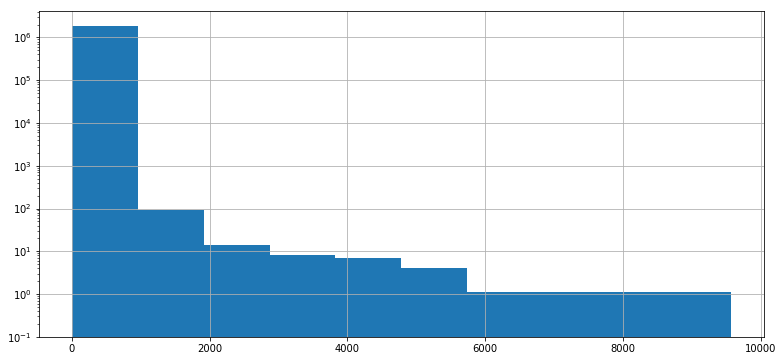

In [15]:
fig, ax = plt.subplots(figsize=(13, 6))
#bins = np.arange(0,60,5) , use bins=bins in hist function below for smaller values
train_df['Quantity'].hist(ax=ax, bottom=0.1)

#formatter = FuncFormatter(log_10_product)
ax.set_yscale('log')


In [16]:
#train_df[train_df['Quantity'] > 500].PRODUCT_NAME.value_counts()

### Visualization

In [17]:
test = df_initial.groupby(by=['DATE','SKU','CATEGORY_LEVEL_1'], as_index=False)['Quantity'].sum()

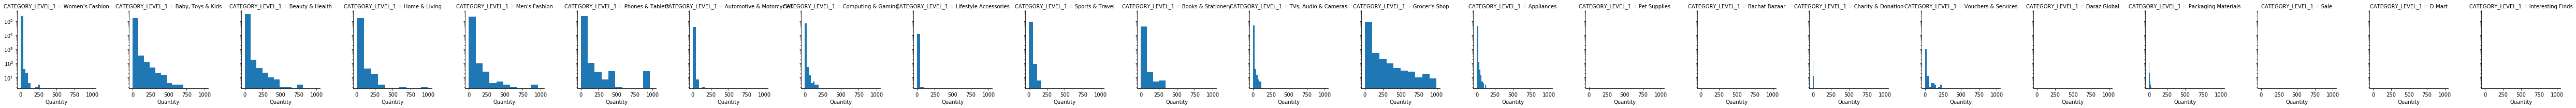

In [18]:
   
g = sns.FacetGrid(test[test.Quantity < 1000], col="CATEGORY_LEVEL_1")
g = g.map(plt.hist, "Quantity", log=True)

### BenchMark Model (Predict Demand as Avergae of last N days demand)

In [14]:
test_df = train_df[(train_df.DATE >= '2018-05-01') & (train_df.Quantity <= 100)]

In [15]:
test_df['PredictedDemand'] = np.int64((test_df.D1+test_df.D2+test_df.D3+test_df.D4+test_df.D5)/5)
#test_df.loc[:,'PredictedDemand'] = test_df['PredictedDemand'].apply(lambda x : log_inf(x))
test_df.head()

/home/danyal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,DATE,SKU,WareHouse,MedianPrice,IsBundle,ProductGender,PRODUCT_NAME,Quantity,D1,D2,D3,D4,D5,PredictedDemand
551000,2018-05-01,MO240HB10XKV0NAFAMZ,Karachi,95.0,1,NEUTRAL,Pack Of 3 - Condoms,1,0,0,0,0,0,0
551001,2018-05-01,DA290FAGDTIPNAFAMZ,Karachi,624.0,1,NEUTRAL,Pack of 2 Sports Laces Bra,1,0,0,0,0,0,0
551002,2018-05-01,DM362EL08S8XINAFAMZ,Karachi,249.0,0,NEUTRAL,3D Screen Enlarger Screen For Smartphones - Black,1,0,0,0,1,0,0
551003,2018-05-01,IM505FA01BH2YNAFAMZ,Karachi,300.0,0,NEUTRAL,Zircon Double Sided Golden Colour 2018 Latest ...,1,0,0,0,0,0,0
551004,2018-05-01,RO070HL0GDBF0NAFAMZ,Karachi,1040.0,0,NEUTRAL,Rotho Cutlery tray 7 compartments DOMINO,2,0,0,0,0,0,0


In [16]:
import math
print("MSE: ",mean_squared_error(test_df.Quantity, test_df.PredictedDemand),
      "RMSE: ",math.sqrt(mean_squared_error(test_df.Quantity, test_df.PredictedDemand))
     )


MSE:  21.006301364908193 RMSE:  4.583263178665196


### ML model Data Prepration

In [16]:
#train_df.drop(axis=1, columns=['Karachi','Lahore'], inplace = True)
if not {'MEN', 'NEUTRAL','Karachi','Lahore'}.issubset(train_df.columns):
    dummyWareHouse = pd.get_dummies(train_df['WareHouse']).astype(int)
    dummyProductGender = pd.get_dummies(train_df['ProductGender']).astype(int)
    train_df = pd.concat([train_df,dummyWareHouse], axis = 1)
    train_df = pd.concat([train_df,dummyProductGender], axis = 1)

In [51]:
train_df['WEEKNO'] = train_df['WEEKNO'].apply(int)
train_df[train_df.SKU == '00301FA025DPKNAFAMZ']

,SKU,WEEKNO,WareHouse,MedianPrice,IsGrocery,IsBundle,ProductGender,PRODUCT_NAME,CatConcat,Quantity,IsHoliday,Karachi,Lahore,MEN,NEUTRAL,WOMAN
0,00301FA025DPKNAFAMZ,18,Karachi,399.0,0,0,MEN,Unisex Style Baseball Cap - Black,Unisex Style Baseball Cap - Black | 0092 store...,1,0,1,0,1,0,0
1,00301FA025DPKNAFAMZ,19,Karachi,399.0,0,0,MEN,Unisex Style Baseball Cap - Black,Unisex Style Baseball Cap - Black | 0092 store...,1,0,1,0,1,0,0
2,00301FA025DPKNAFAMZ,21,Karachi,399.0,0,0,MEN,Unisex Style Baseball Cap - Black,Unisex Style Baseball Cap - Black | 0092 store...,1,0,1,0,1,0,0
3,00301FA025DPKNAFAMZ,48,Karachi,399.0,0,0,MEN,Unisex Style Baseball Cap - Black,Unisex Style Baseball Cap - Black | 0092 store...,0,1,1,0,1,0,0
0,00301FA025DPKNAFAMZ,19,Lahore,399.0,0,0,MEN,Unisex Style Baseball Cap - Black,Unisex Style Baseball Cap - Black | 0092 store...,4,0,0,1,1,0,0
1,00301FA025DPKNAFAMZ,20,Lahore,399.0,0,0,MEN,Unisex Style Baseball Cap - Black,Unisex Style Baseball Cap - Black | 0092 store...,2,0,0,1,1,0,0
2,00301FA025DPKNAFAMZ,21,Lahore,399.0,0,0,MEN,Unisex Style Baseball Cap - Black,Unisex Style Baseball Cap - Black | 0092 store...,1,0,0,1,1,0,0
3,00301FA025DPKNAFAMZ,48,Lahore,399.0,0,0,MEN,Unisex Style Baseball Cap - Black,Unisex Style Baseball Cap - Black | 0092 store...,0,1,0,1,1,0,0


#### **Train Test Data Split

In [18]:
#train_df[(~train_df.WEEKNO.isin(testWeeks)) & (train_df.Quantity > 600)]['CatConcat'].value_counts()

In [21]:
colList = ['WEEKNO','Lahore','IsHoliday','IsGrocery','IsBundle','MEN','NEUTRAL','MedianPrice']
testWeeks = [19,20,21,22]
X = train_df[~train_df.WEEKNO.isin(testWeeks)][colList]
#X.MedianPrice = X.MedianPrice.map(log_inf)
Y_orig = train_df[~train_df.WEEKNO.isin(testWeeks)][['Quantity']]
#Y = Y_orig.Quantity.map(log_inf)
Y = Y_orig

In [22]:
X_test = train_df[train_df.WEEKNO.isin(testWeeks)][colList]
#X_test.MedianPrice = X_test.MedianPrice.map(log_inf)
Y_test_orig = train_df[train_df.WEEKNO.isin(testWeeks)][['Quantity']]
#Y_test = Y_test_orig.Quantity.map(log_inf)
Y_test = Y_test_orig
#X_test_SKUs = train_df[(train_df.DATE >= '2018-05-01') & (train_df.Quantity <= 200)][['SKU']]


#### **Decision Tree Regression Model

In [23]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(max_depth=6,min_samples_split=10,min_samples_leaf=10)
regr.fit(X, Y)
y_pred = regr.predict(X_test)

import math
print("MSE: ",mean_squared_error((Y_test), (y_pred)),
      "RMSE: ",math.sqrt(mean_squared_error((Y_test), (y_pred)))
     )


MSE:  1554.2569792141378 RMSE:  39.424065990383816


In [87]:
X_test['Actual'] = Y_test
X_test['Predicted'] = y_pred
#X_test['Actual'] = X_test['Actual'].map(np.exp)
#X_test['Predicted'] = X_test['Predicted'].map(np.exp)
#X_test[X_test.Actual > 5].head(100)
#X.MedianPrice.describe()
print('Total Actual Demand : ',X_test.Actual.sum(),'\nTotal Predicted Demand : ',X_test.Predicted.sum())

X_test[X_test.Actual >1][['Actual','Predicted']].head()

Total Actual Demand :  708282 
Total Predicted Demand :  590826.3794632072


Actual       71772
Predicted    71772
dtype: int64

In [40]:
from sklearn.tree import export_graphviz
import os
import subprocess

def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [42]:
features = ['WeekDayNo','Lahore','IsBundle','MEN','NEUTRAL']
visualize_tree(regr, features)

In [87]:

main_list = list(set(X_test.SKU.unique())-set(X.SKU.unique()))
len(main_list)



AttributeError: 'DataFrame' object has no attribute 'SKU'

### XGBOOST Model

In [49]:
from xgboost import XGBRegressor

from xgboost.sklearn import XGBRegressor  
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(1, 20)

params = {  
    "n_estimators": st.randint(3, 10),
    "max_depth": st.randint(3, 10),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(n_estimators=10) 

xgbreg.fit(X, Y)
y_pred = xgbreg.predict(X_test)

import math
print("MSE: ",mean_squared_error((Y_test), (y_pred)),
      "RMSE: ",math.sqrt(mean_squared_error((Y_test), (y_pred)))
     )


MSE:  1556.7458358981169 RMSE:  39.45561855931442


### Polynomial Regression

In [48]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# create a Linear Regressor   
lin_regressor = LinearRegression()

# pass the order of your polynomial here  
poly = PolynomialFeatures(2)

# convert to be used further to linear regression
X_transform = poly.fit_transform(X)

# fit this to Linear Regressor
lin_regressor.fit(X_transform,Y.Quantity) 

# get the predictions
y_pred = lin_regressor.predict(X_test)

import math
print("MSE: ",mean_squared_error((Y_test), (y_pred)),
      "RMSE: ",math.sqrt(mean_squared_error((Y_test), (y_pred)))
     )


ValueError: shapes (386632,5) and (21,) not aligned: 5 (dim 1) != 21 (dim 0)

In [91]:
temp = X_test
temp['Pred'] = y_pred
temp['Act'] = Y_test

temp[temp.Act >= 10]

1.8577507

### GridSearch For Best Model 

In [107]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
gs.fit(X, Y)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [108]:
gs.best_estimator_

D1               int64
D2               int64
MedianPrice    float64
WeekDayNo        int64
Lahore           uint8
IsBundle         int64
dtype: object

In [ ]:
y_pred = gs.best_estimator_.predict(X_test)

import math
print("MSE: ",mean_squared_error((Y_test), (y_pred)),
      "RMSE: ",math.sqrt(mean_squared_error((Y_test), (y_pred)))
     )
